<a href="https://colab.research.google.com/github/mamrsantos/Projeto-Aplicado-IGTI/blob/main/ProjetoAplicado_IGTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delieamento do Estudo

## Estratégia de Análise

**Questões do Estudo**: 
 1. Quais os principais fatores que levam os usuários a converter a compra? 
 2. Podemos prever qual revendedor (se houver) seria escolhido na lista de Ofertas? 

**DataSets**: 

**TreiningSet**

- DealerId              - Identificado único de um revendedor
- Conversion            - Booleano para se o usuário converteu
- long                  - Longitude of the user's location
- lat                   - Latitude of the user's location
- deviceid              - Identificado único do usuario
- EventTimestamp        - O carimbo de data / hora UTC da lista de ofertas
- DealerOpened          - Se o revendedor estava aberto ou fechado. Revendedor - fechados não conseguem vender
- Distributor           - A marca da botija de gás
- Position              - Posição do item na lista
- Quality               - Índice de qualidade com base nas avaliações do usuário
- DealerETAGroup        - O tempo estimado de entrega
- RecommendationType    - Um emblema atribuído para destacar boas ofertas
- Price                 - Preço da botija de gás
- SearchId              - Identificador único da lista de ofertas

**CityState**

- CityId                - Unique city identifier	
- State                 - State name
- City                  - City name
- Geography             - City polygon

## Métodos

<p align = "justify"> Além das estatísticas básicas comumente utilizadas (preço médio, número de revendedores por listagem ...), o objetivo dessa análise foi desenvolver  um modelo preditivo que permitisse identificar os principais fatores que influenciam a decisão do usuário pela compra, assim como, aplica-lo na construção  ranking por revendedores, estimando a  probabilidade de conversão em uma lista. Segue as etapas a serem desenvolvidas: </p>

1. **Importação dos DataSets**: Acessando o BIGQUERY para leitura e importação dos DataSets (TreiningSet e CiyState); 

2. **Merge das TrainingSet e CitySate**: Em ambas tabelas possui um campo de geolocalização: 
    - TrainingSet - Logitude (long) e Latitude (lat)
    - CitySate - Geography (dimensão geográfica por cidade)

  Foi realizado o merge para buscar a cidade de localização do usuário ao acessar o app CHAMA;

3. **Pré-tratamento dos dados**: Verificação de campos nulos, dropando colunas desnecessárias e criando novos atributos (variáveis);

4. **Análise Exploratorio dos Dados**: Explorando a distribuição das variáveis a partir da estrutura definida - Usuário, Revendedor e Lista; 

5. **Preparação dos dados para Modelo (Universo do Estudo - São Paulo)**: O DataSet delineado teve a granulalidade reduzida por lista - SearchId . Sendo assim, todos os atributos relacionados ao revendedor, optou-se por uma métrica estatística adequada para o agrupamento.   

6. **Modelo Preditivo**: Estimação e validação do modelo:
    - Foi solicitado que "NÃO" era necessário treinar o modelo. Entretanto, realizou a segmentação com objetivo mensura a acuraria do modelo proposto, sendo utilizado na sequência, para estimar a probabilidade de conversão do revendedor a ser escolhido em uma lista;  
    



# Importação dos DataSets

## Bibliotecas Importantes

In [47]:
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
!pip install geopandas
!pip install shapely
!pip install pygeos
!pip install rtree
!pip3 install rtree
!pip install geopandas
!pip install remodel
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from datetime import datetime 
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import sqlite3 as sql
import sqlite3
import plotly.express as px
from pandas.plotting import scatter_matrix, parallel_coordinates
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import glob
from bs4 import BeautifulSoup
from requests import get  

## Credenciais no Goolge para acessar o BIGQUERY

A primeira vez que executar o comando abaixo, será necessário clicar no link e copiar a credencias de acesso ao BigQuery


In [48]:
# Autenticação para acessar o BigQuery

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [49]:
# Pacote que pode ser usado para exibir grandes dataframes do pandas como uma tabela de dados

%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Declarando o ID do projeto do Cloud que será usado para acessar os dados

In [50]:
# Declaração do projeto na Cloud e acessando

project_id = 'chama-bi-recruitment'
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

## Importando os conjuntos de dados "TrainingSet" e "CityState"

In [51]:
# Tabela TrainingSet

TrainingSet = client.query('''SELECT * FROM `chama-bi-recruitment.Conversion.TrainingSet`''').to_dataframe()

In [52]:
TrainingSet.shape

(615932, 14)

In [53]:
# Visualizando o conjunto de dados 

TrainingSet.head()

DealerId  ...                                           SearchId
0  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=  ...  __DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=...
1  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=  ...  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...
2  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=  ...  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...
3  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=  ...  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...
4  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=  ...  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...

[5 rows x 14 columns]

In [54]:
# Conferindo a Typagem dos atributos 

TrainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615932 entries, 0 to 615931
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   DealerId            615932 non-null  object             
 1   Conversion          615932 non-null  int64              
 2   long                615932 non-null  float64            
 3   lat                 615932 non-null  float64            
 4   deviceid            615932 non-null  object             
 5   EventTimestamp      615932 non-null  datetime64[ns, UTC]
 6   DealerOpened        615932 non-null  bool               
 7   Distributor         615932 non-null  object             
 8   Position            615932 non-null  int64              
 9   Quality             615932 non-null  float64            
 10  DealerETAGroup      615932 non-null  object             
 11  RecommendationType  615247 non-null  object             
 12  Price           

In [55]:
# Tabela CityState

CityState= client.query('''SELECT * FROM `chama-bi-recruitment.GeographyBrazil.CityState`''').to_dataframe()

In [56]:
CityState.shape

(5517, 4)

In [57]:
# Visualizando o conjunto de dados CityState

CityState.head(1)

CityId  ...                                          Geography
0    2930  ...  POLYGON((-72.805927 -7.687039, -72.806833 -7.6...

[1 rows x 4 columns]

In [58]:
# Conferindo a Typagem dos atributos 

CityState.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CityId     5517 non-null   int64 
 1   State      5517 non-null   object
 2   City       5517 non-null   object
 3   Geography  5516 non-null   object
dtypes: int64(1), object(3)
memory usage: 172.5+ KB


In [59]:
# Salvando os conjuntos de dados localmente

TrainingSet.to_csv("TrainingSet.csv")
CityState.to_csv("CityState.csv")

# Merge das TrainingSet e CitySate 

Ambas as tabelas apresentam dados geograficos a serem relacionados, entretanto, para isso sera necessário preparar as chaves de relacionamento de ambas as tabelas: 

- **DataSet TrainingSet** - Longuitude (long) e Latitude (lat) - Será criado um ponto geográrico no conjunto de dados;

- **DataSet CityState** - haverá apenas uma transformação no campo Geography. Será renomeado e tipado como geometrico. 

Observação: Foi utilizado o pacote python "geopandas".



**DataSet TraininSet**

Inserido no conjunto de dados TrainingSet a localização de ponto

In [60]:
# Definindo o conjunto de dados TrainingSet como GeodataFrame

TrainingSet = geopandas.GeoDataFrame(TrainingSet, geometry=geopandas.points_from_xy(TrainingSet.long, TrainingSet.lat))

In [61]:
# Visualizando o DataSet TrainingSet

TrainingSet.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 615932 entries, 0 to 615931
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   DealerId            615932 non-null  object             
 1   Conversion          615932 non-null  int64              
 2   long                615932 non-null  float64            
 3   lat                 615932 non-null  float64            
 4   deviceid            615932 non-null  object             
 5   EventTimestamp      615932 non-null  datetime64[ns, UTC]
 6   DealerOpened        615932 non-null  bool               
 7   Distributor         615932 non-null  object             
 8   Position            615932 non-null  int64              
 9   Quality             615932 non-null  float64            
 10  DealerETAGroup      615932 non-null  object             
 11  RecommendationType  615247 non-null  object             
 12  Price   

**DataSet CityState**

In [62]:
# Definindo o conjunto de dados CityState como GeodataFrame

CityState = geopandas.GeoDataFrame(CityState)

In [63]:
# Definindo o ponto geográfico 

CityState = CityState.rename(columns={'Geography':'geometry'})
CityState['geometry'] = gpd.GeoSeries.from_wkt(CityState['geometry'])

In [64]:
# Visualizando a type das tabela

CityState.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CityId    5517 non-null   int64   
 1   State     5517 non-null   object  
 2   City      5517 non-null   object  
 3   geometry  5516 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 172.5+ KB


In [65]:
# Visualizando o conjunto de dados 

CityState.head(2)

CityId  ...                                           geometry
0    2930  ...  POLYGON ((-72.80593 -7.68704, -72.80683 -7.686...
1    2920  ...  POLYGON ((-71.55530 -8.64739, -71.56645 -8.647...

[2 rows x 4 columns]

**Merge das Tabelas TraininSet x CityState

In [66]:
# Dataframe após merge das tabealas

df = geopandas.sjoin(TrainingSet,CityState, how="left", op='intersects')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [67]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 615932 entries, 0 to 615931
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   DealerId            615932 non-null  object             
 1   Conversion          615932 non-null  int64              
 2   long                615932 non-null  float64            
 3   lat                 615932 non-null  float64            
 4   deviceid            615932 non-null  object             
 5   EventTimestamp      615932 non-null  datetime64[ns, UTC]
 6   DealerOpened        615932 non-null  bool               
 7   Distributor         615932 non-null  object             
 8   Position            615932 non-null  int64              
 9   Quality             615932 non-null  float64            
 10  DealerETAGroup      615932 non-null  object             
 11  RecommendationType  615247 non-null  object             
 12  Price   

# Pré-tratamento dos dados

Dropando Missing

Ao analisar a função seguir, nota-se valor nulos na variáveis RecomendationTypy e com atributos relacionado do dataset CitySate. Nesses casos, decidiu-se pela exclusão das linhas com valores nulos.

In [68]:
# Verificando a frequência com valores nulos

df.isna().sum()

DealerId                0
Conversion              0
long                    0
lat                     0
deviceid                0
EventTimestamp          0
DealerOpened            0
Distributor             0
Position                0
Quality                 0
DealerETAGroup          0
RecommendationType    685
Price                   0
SearchId                0
geometry                0
index_right            85
CityId                 85
State                  85
City                   85
dtype: int64

In [69]:
# dropando todas as linhas com valores nulos

df.dropna(inplace=True) 

In [70]:
df.isna().sum()

DealerId              0
Conversion            0
long                  0
lat                   0
deviceid              0
EventTimestamp        0
DealerOpened          0
Distributor           0
Position              0
Quality               0
DealerETAGroup        0
RecommendationType    0
Price                 0
SearchId              0
geometry              0
index_right           0
CityId                0
State                 0
City                  0
dtype: int64

In [71]:
# Visualizando o DataFrame 

df.head()

DealerId  Conversion  ...      State  City
0  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  Sao Paulo  Mauá
1  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  Sao Paulo  Mauá
2  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  Sao Paulo  Mauá
3  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  Sao Paulo  Mauá
4  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  Sao Paulo  Mauá

[5 rows x 19 columns]

In [72]:
# removendo algumas colunas 

cols_to_drop = ["long","lat","index_right","CityId"]
df = df.drop(cols_to_drop, axis=1)

## Tratando EventTimestamp

Essa variável representa a data da lista ofertada. Nesse primeiro momento, será criado algumas variaveis derivadas da data que pode ser utilizada posteriormente. 

In [73]:
# Criando as variáveis "Dia_da_semana", "dia_mes", "mes", "ano" e "hora" respectivamente

#date = datetime.strptime(str_date, '%d/%m/%Y').date()
df['date'] = df['EventTimestamp'].dt.strftime('%d/%m/%Y')
df['dia_da_semana'] = df['EventTimestamp'].dt.strftime("%A")
df['dia_mes'] = df['EventTimestamp'].dt.strftime("%d")
df['mes'] = df['EventTimestamp'].dt.strftime("%B")
df['ano'] = df['EventTimestamp'].dt.year
df['hora'] = df['EventTimestamp'].dt.strftime("%H")

In [74]:
df.head()

DealerId  Conversion  ...   ano hora
0  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  2019   23
1  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  2019   17
2  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  2019   21
3  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  2019   16
4  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0  ...  2019   17

[5 rows x 21 columns]

# Análise Exploratorio dos Dados

<p align = "justify"> Esta seção apresenta algumas estatísticas relacionadas às três dimensões da granularidade do DataFrame (usuário, revendedor e lista de cotações). O objetivo principal é entender a distribuição de atributos de forma granular por meio de análises exploratórias e comparar as informações com variáveis ​​de "transformação" quando possível.</p>

**Dados do Usuário**

- long                  - Longitude of the user's location
- lat                   - Latitude of the user's location
- deviceid              - Identificado único do usuario

**Dados do Revendedor**-

- DealerId              - Identificado único de um revendedor
- DealerOpened          - Se o revendedor estava aberto ou fechado. Revendedor - fechados não conseguem vender
- Distributor           - A marca da garrafa de gás
- Position              - Posição do item na lista
- Quality               - Índice de qualidade com base nas avaliações do usuário
- DealerETAGroup        - O tempo estimado de entrega
- RecommendationType    - Um emblema atribuído para destacar boas ofertas
- Price                 - Preço da garrafa de gás

**Dados da Lista**

- SearchId              - Identificador único da lista de ofertas
- EventTimestamp        - O carimbo de data / hora UTC da lista de ofertas
- Conversion            - Booleano para se o usuário converteu

### Dados do Usuário

deviceid

No geral, do conjunto de dados tem 19472 usuarios que utilizadaram aplicativos. Na tabela a seguir, é possível verificar a quantidade de conversões (compras) por usuários.

In [108]:
# Criando uma tabela auxiliar por usuário
dfus = df.groupby(['deviceid','State','City'], as_index=False)
dfus = dfus.agg({'Conversion':'sum','date':'min'})
dfus.columns = list(map(''.join, dfus .columns.values))

In [109]:
dfus

deviceid  ...        date
0      __++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=  ...  24/08/2019
1      __++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=  ...  12/06/2019
2      __++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=  ...  05/07/2019
3      __++c79jNZqUobJxlJ3btmFMU2aiN08U/GsIMl08qWm84=  ...  28/06/2019
4      __++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=  ...  29/06/2019
...                                               ...  ...         ...
19428  __zyn3bYHjkDnEjRj0Tz7MCT6T1TbbX12DD51vbni4UTo=  ...  15/08/2019
19429  __zz+B0xPn0cAtGTCnvVl7didVjfkLZ6t7xL2r9FkWCbc=  ...  30/06/2019
19430  __zz+gPAnKSu8mvo1yJswKvOSd8uWQ9kLa3+EzJU4yhiM=  ...  11/07/2019
19431  __zzrIeic78upwBHedZRdxhosPIgbTuTNGTWehyr00raw=  ...  06/07/2019
19432  __zzuQAy0oBi2FSrmKdd3G3lPGuNSn7ACBgxMMnhnExhI=  ...  17/07/2019

[19433 rows x 5 columns]

Analisando a tabela abaixo, evidencia que quase 14% dos usuarios fizeram compras no app. 

In [110]:
# Distribuição dos usuários por quantidade de conversão. 
dfus.Conversion.value_counts(normalize=True)

0    0.864972
1    0.133124
2    0.001853
4    0.000051
Name: Conversion, dtype: float64

In [111]:
# Substituindo conversões 2 e 4 por 1 no conjunto de dados principal (df)

df.Conversion.replace(2, 1, inplace=True)
df.Conversion.replace(4, 1, inplace=True)
df.Conversion.replace(3, 1, inplace=True)
df.Conversion.value_counts(normalize=True)

0    0.995671
1    0.004329
Name: Conversion, dtype: float64

Cerca 82,34% dos usuários estão localizados no estado de São Paulo

In [112]:
# Distribuição dos usuários por estado 
dfus.State.value_counts(normalize=True)

Sao Paulo            0.823650
Minas Gerais         0.106829
Rio Grande do Sul    0.051459
Paraná               0.014151
Distrito Federal     0.003911
Name: State, dtype: float64

In [113]:
# Criando variáveis binarias no conjunto de dados transformado (dft)
dft = df
#dft = pd.get_dummies(df, columns = ['State'])

42,38% dos clientes estão localizado no municipio de São Paulo, no geral 27 cidades representam quase 98% dos usuários do conjunto de dados analisando. 

In [114]:
# Distribuição dos usuários por Cidade
dfus_cid = pd.DataFrame(dfus.City.value_counts(normalize=True))
dfus_cid  = dfus_cid.sort_values(by='City',ascending=False)
dfus_cid["cumpercentage"] = dfus_cid["City"].cumsum()/dfus_cid["City"].sum()*100

No handles with labels found to put in legend.


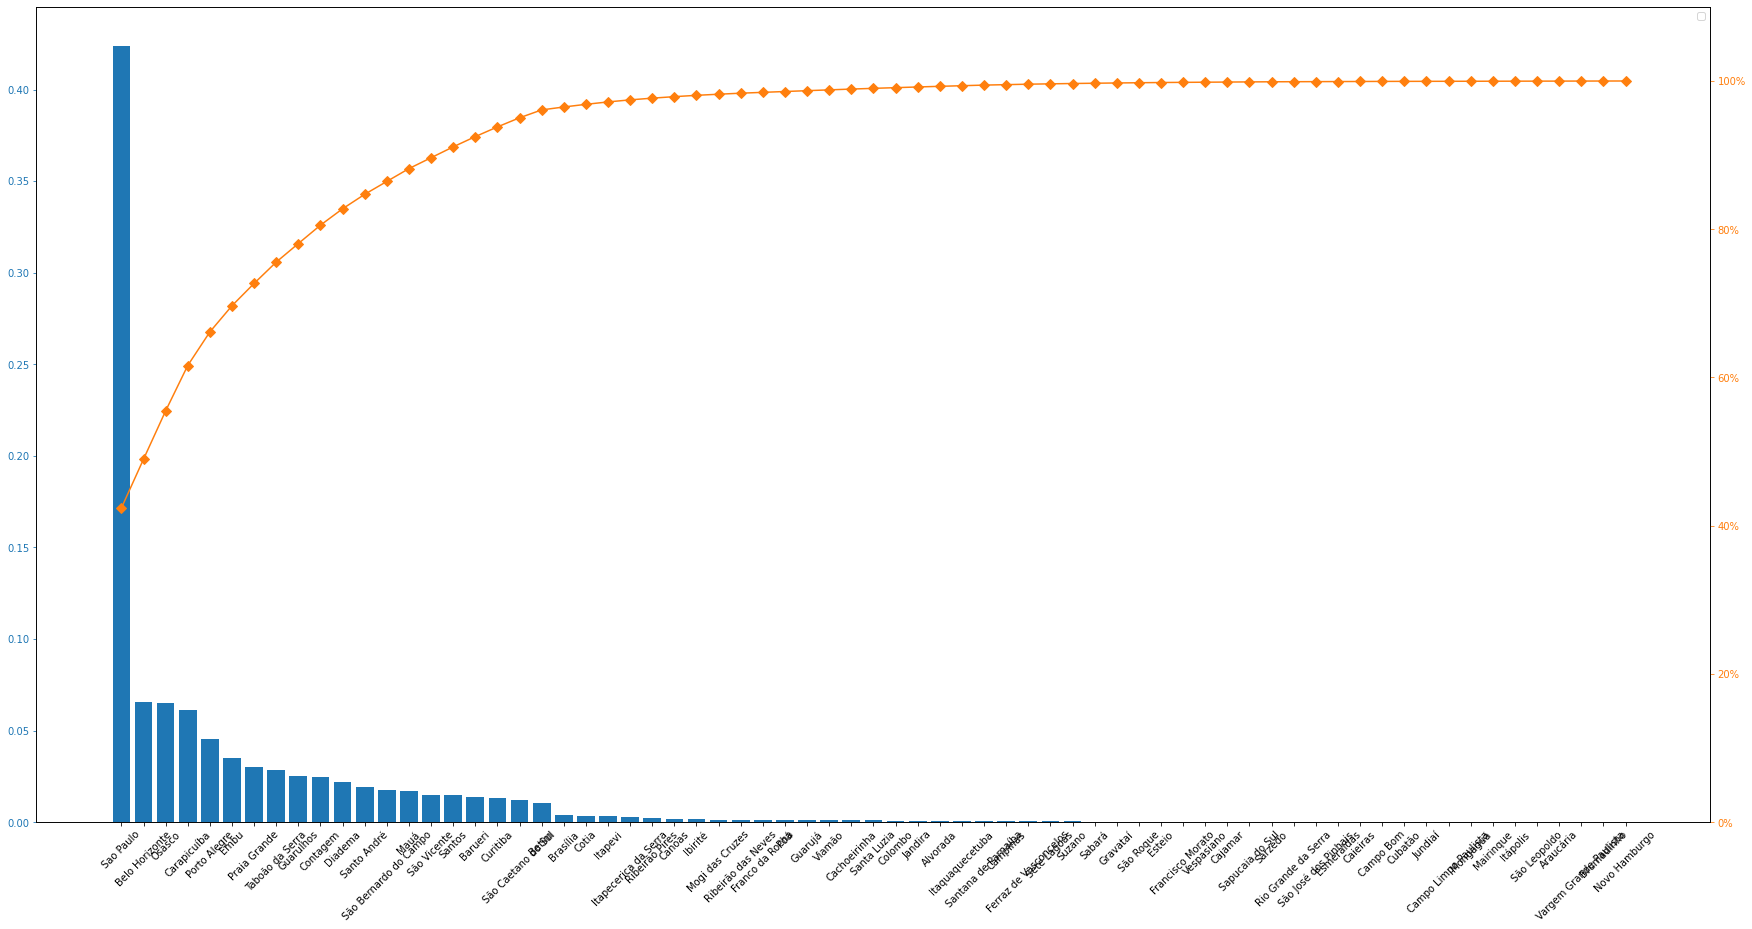

In [115]:
# Gerando o gráfico de paretro com distribuição de usuários por Cidade

from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(figsize=(30,15))
ax.bar(dfus_cid.index, dfus_cid["City"], color="C0")
ax2 = ax.twinx()
ax2.plot(dfus_cid.index, dfus_cid["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Configurações dos eixos 
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax2.set_ylim([0,110])

# Ajusta a inclinação dos labels do eixo x
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Finalmente mostra o grafico definido acima
plt.legend() 
plt.show()


In [116]:
dfus_cid

City  cumpercentage
Sao Paulo               0.423918      42.391808
Belo Horizonte          0.065867      48.978542
Osasco                  0.065147      55.493233
Carapicuíba             0.061236      61.616837
Porto Alegre            0.045335      66.150363
...                          ...            ...
São Leopoldo            0.000051      99.979416
Araucária               0.000051      99.984562
Vargem Grande Paulista  0.000051      99.989708
Brumadinho              0.000051      99.994854
Novo Hamburgo           0.000051     100.000000

[69 rows x 2 columns]

### Dados do Revendedor

Nessa etapa os revendedores serão agrupados por estado, para entendimento do perfil e preços médio praticados nas listas ofertadas.

No caso dos revendedores, tem três variáveis que pode haver alterações de uma anuncio (lista) para outro. Nesta analise de revendedores, serão deixadas de fora, mas na sequência, transformadas em variáveis binarias no dataframe transformação (dft).


In [117]:
# Criando uma tabela auxiliar por revendedor

dfrev= df.groupby(['DealerId',"State"], as_index=False)
dfrev= dfrev.agg({'Conversion':'sum',
                  'date':'min',
                  'Price':["mean"],
                  'Quality':["mean"],
                  'Position':["mean"]})
dfrev.columns = list(map(''.join, dfrev.columns.values))


 No geral, no conjunto de dados têm 1834 revendedores. 

In [118]:
dfrev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1834 entries, 0 to 1833
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DealerId       1834 non-null   object 
 1   State          1834 non-null   object 
 2   Conversionsum  1834 non-null   int64  
 3   datemin        1834 non-null   object 
 4   Pricemean      1834 non-null   float64
 5   Qualitymean    1834 non-null   float64
 6   Positionmean   1834 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 114.6+ KB


In [119]:
dfrev.head()

DealerId  ... Positionmean
0  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=  ...     4.712032
1  __+8XmsU3LLXtVj5SyXHYY0D64RynJANGeifXDiUFzDc8=  ...     6.724138
2  __+AX16Klw83OSwUSI3XJu71zUjBYvgWx6cTReL4VTbRE=  ...     8.531250
3  __+FOaLWh6YMAqnXW3e2ksrWs8n24EwmkNZNefrpfdBxI=  ...     3.765625
4  __+Ggvnlp+IvfHyK2PxT2NBIhYNuwl5yzEJzPjSjI04AQ=  ...     9.752161

[5 rows x 7 columns]

Como era de espera, a maioria dos revendedores são do estado de São Paulo (80%). 

In [120]:
# Distribuição dos revendedores por estado 

dfrev.State.value_counts(normalize=True)

Sao Paulo            0.799891
Minas Gerais         0.101963
Rio Grande do Sul    0.045802
Paraná               0.035442
Distrito Federal     0.016903
Name: State, dtype: float64

A tabela a seguir, expoe a distribuição média dos preço por estado. A maior média observada foi identificada no Distrito Federal, com preço médio de R\$ 74,55, sendo seguido por São Paulo com preço médio de R\$ 73,78. 

In [121]:
# Estatística descritiva por estado (Preço)

resumo = dfrev.groupby('State').agg({'Pricemean':['mean','std', 'min','median','max','count']})
resumo

Pricemean                                                  
                        mean       std        min     median         max count
State                                                                         
Distrito Federal   74.551802  7.892131  60.000000  72.000000   92.083333    31
Minas Gerais       73.228410  4.902978  64.603522  72.464673   89.000000   187
Paraná             72.427130  4.368684  64.978571  71.500000   84.998125    65
Rio Grande do Sul  72.597566  4.066296  66.337391  71.816421   84.002397    84
Sao Paulo          73.784913  6.972647  23.300000  72.780440  120.000000  1467

Ao analisar o número medio de conversão (total de conversão), nota-se uma maior média no estado do Rio Grande do Sul. Em todos os estados, 50% dos revendedores não tiveram conversão de vendas. 

In [122]:
# Estatística descritiva por estado (Conversion)

resumo = dfrev.groupby('State').agg({'Conversionsum':['mean','std', 'min','median','max','count']})
resumo

Conversionsum                               
                           mean       std min median max count
State                                                         
Distrito Federal       0.193548  0.401610   0      0   1    31
Minas Gerais           1.347594  2.720300   0      0  18   187
Paraná                 0.492308  1.404491   0      0   9    65
Rio Grande do Sul      2.071429  4.433676   0      0  19    84
Sao Paulo              1.498978  3.119357   0      0  36  1467

A matriz de correlação abaixo exibe os coeficientes de correlação dos indicadores por revendedor, nota-se que: 

- a maior correlação absoluta observada foi entre preço (Pricemean) e total de conversão (Conversionsum), indicando quanto menor o preço praticado pelo revendendor maior o número de conversões. 
- A variável "Quality", apresentou uma correlação fraca com conversão, mas sinal positivo. Isso pressupoe que, quanto maior for avaliação do revendedor mais ele converte venda. 
- o indicador position, e altamente correlacionado com preço. A correlação dessa variável com total de conversão (ConvesionSum) tambem foi negativa. 

In [123]:
dfrev.corr()

Conversionsum  Pricemean  Qualitymean  Positionmean
Conversionsum       1.000000  -0.232881     0.053828     -0.094913
Pricemean          -0.232881   1.000000    -0.019942      0.438278
Qualitymean         0.053828  -0.019942     1.000000     -0.148044
Positionmean       -0.094913   0.438278    -0.148044      1.000000

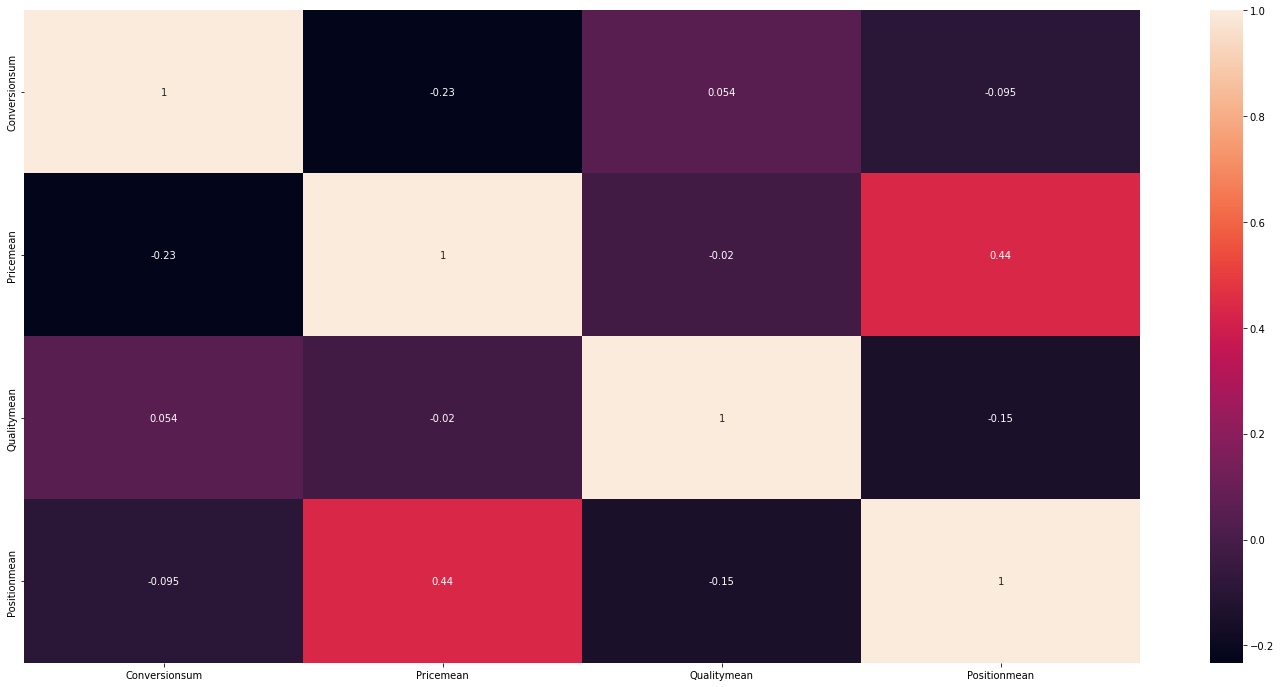

In [124]:
# Matriz de correlação 

plt.figure(figsize=(25,12))
p = sns.heatmap(data=dfrev.corr(method='pearson'), annot=True)

 Transformação Binarias das variáveis para base do modelo preditivo: 
 
- DealerETAGroup
- RecommendationType 

In [125]:
dft = pd.get_dummies(dft, columns = ['DealerETAGroup','Distributor','RecommendationType'])

### Dados da Lista

A ideia nessa etapa é semelhante ao que se fez na seção "Dados do Revendedor". Inicialmente, criar uma tabela com as listas e respectivas média de preços, quality e posição, além de avaliar a distribuição das listas por estado. 

In [126]:
# Criando uma tabela auxiliar das Listas
dflist= df.groupby(['SearchId',"State","date","dia_da_semana","dia_mes","mes","hora","ano"], as_index=False)
dflist= dflist.agg({'Conversion':'sum',
                  'Price':["mean"],
                  'Quality':["mean"],
                  'Position':["mean"]})
dflist.columns = list(map(''.join, dflist.columns.values))

In [127]:
dflist.head()

SearchId  ... Positionmean
0  __++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=...  ...          4.5
1  __++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...  ...          4.5
2  __++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...  ...          4.5
3  __++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=...  ...         13.0
4  __++c79jNZqUobJxlJ3btmFMU2aiN08U/GsIMl08qWm84=...  ...          3.0

[5 rows x 12 columns]

In [128]:
dflist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40656 entries, 0 to 40655
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SearchId       40656 non-null  object 
 1   State          40656 non-null  object 
 2   date           40656 non-null  object 
 3   dia_da_semana  40656 non-null  object 
 4   dia_mes        40656 non-null  object 
 5   mes            40656 non-null  object 
 6   hora           40656 non-null  object 
 7   ano            40656 non-null  int64  
 8   Conversionsum  40656 non-null  int64  
 9   Pricemean      40656 non-null  float64
 10  Qualitymean    40656 non-null  float64
 11  Positionmean   40656 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 4.0+ MB


Frequência de Lista por Estado

In [129]:
# Distribuição das listas por estado 
dflist.State.value_counts(normalize=True)

Sao Paulo            0.780229
Minas Gerais         0.144284
Rio Grande do Sul    0.062574
Paraná               0.010552
Distrito Federal     0.002361
Name: State, dtype: float64

**Preço Médio** - Estatística descritivas das Listas por estado

In [130]:
# Estatística descritiva por estado (Preço) por Lista
resumo = dflist.groupby('State').agg({'Pricemean':['mean','std', 'min','median','max','count']})
resumo

Pricemean                                                  
                        mean       std        min     median        max  count
State                                                                         
Distrito Federal   80.814265  6.008394  72.856429  81.642500  95.500000     96
Minas Gerais       72.904586  1.795835  67.083000  73.072679  81.747500   5866
Paraná             75.157556  2.029015  68.966667  75.369000  79.422222    429
Rio Grande do Sul  71.540786  2.128731  65.393333  71.288889  79.000000   2544
Sao Paulo          73.928033  5.050188  40.956000  72.878421  95.963333  31721

**Conversion** - Estatística descritivas das Listas por estado

In [131]:
# Estatística descritiva por estado (Conversion) por Lista
resumo = dflist.groupby('State').agg({'Conversionsum':['mean','std', 'min','median','max','count']})
resumo

Conversionsum                                
                           mean       std min median max  count
State                                                          
Distrito Federal       0.062500  0.243332   0      0   1     96
Minas Gerais           0.042959  0.202783   0      0   1   5866
Paraná                 0.074592  0.263039   0      0   1    429
Rio Grande do Sul      0.068396  0.252474   0      0   1   2544
Sao Paulo              0.069323  0.254379   0      0   2  31721

In [132]:
dflist.head()

SearchId  ... Positionmean
0  __++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=...  ...          4.5
1  __++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...  ...          4.5
2  __++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...  ...          4.5
3  __++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=...  ...         13.0
4  __++c79jNZqUobJxlJ3btmFMU2aiN08U/GsIMl08qWm84=...  ...          3.0

[5 rows x 12 columns]

**Analise Temporal**

In [133]:
dflist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40656 entries, 0 to 40655
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SearchId       40656 non-null  object 
 1   State          40656 non-null  object 
 2   date           40656 non-null  object 
 3   dia_da_semana  40656 non-null  object 
 4   dia_mes        40656 non-null  object 
 5   mes            40656 non-null  object 
 6   hora           40656 non-null  object 
 7   ano            40656 non-null  int64  
 8   Conversionsum  40656 non-null  int64  
 9   Pricemean      40656 non-null  float64
 10  Qualitymean    40656 non-null  float64
 11  Positionmean   40656 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 5.3+ MB


**Mês** - Distribuições das Listas

In [134]:
dflist['date'] = pd.to_datetime(dflist['date'])

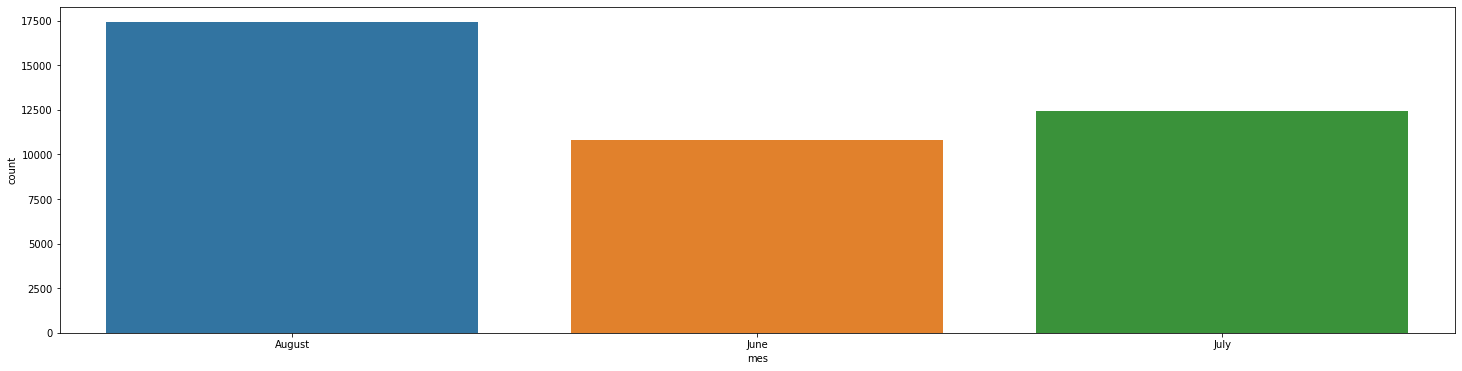

Tabela de Dupla entrada - Conversion x Mês
mes                August        July        June         All
Conversionsum                                                
0               91.576227   95.296573   94.370247   93.457300
1                8.418030    4.687375    5.629753    6.535321
2                0.005742    0.016053    0.000000    0.007379
All            100.000000  100.000000  100.000000  100.000000


In [135]:
plt.figure(figsize=(25,6))
sns.countplot(x='mes', data=dflist)
plt.show()
print("Tabela de Dupla entrada - Conversion x Mês")
tab = pd.crosstab(index=[dflist["Conversionsum"]],columns=dflist["mes"],margins=True)
print(100*(tab/tab.loc['All']))

**Dia_mês** - Distribuição das Listas

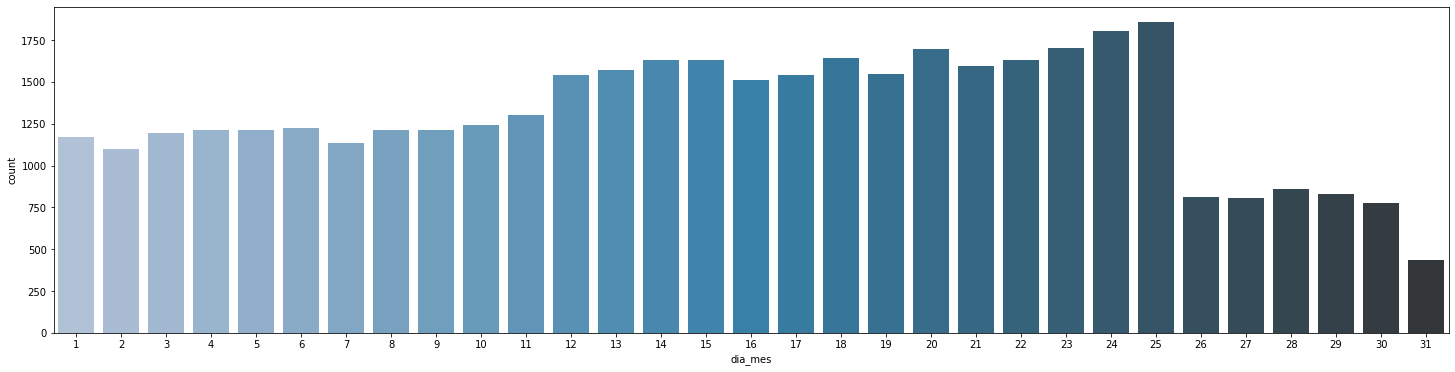

Tabela de Dupla entrada - Conversion x Mês
Conversionsum         0         1         2  All
dia_mes                                         
1              0.943734  0.056266  0.000000  1.0
2              0.950954  0.049046  0.000000  1.0
3              0.947324  0.052676  0.000000  1.0
4              0.949628  0.050372  0.000000  1.0
5              0.959504  0.040496  0.000000  1.0
6              0.951837  0.048163  0.000000  1.0
7              0.949824  0.050176  0.000000  1.0
8              0.951240  0.048760  0.000000  1.0
9              0.966200  0.033800  0.000000  1.0
10             0.953339  0.046661  0.000000  1.0
11             0.947086  0.052914  0.000000  1.0
12             0.918884  0.081116  0.000000  1.0
13             0.918523  0.081477  0.000000  1.0
14             0.909425  0.090575  0.000000  1.0
15             0.909258  0.090742  0.000000  1.0
16             0.913964  0.086036  0.000000  1.0
17             0.913692  0.086308  0.000000  1.0
18             0.923966  0

In [136]:
dflist['dia_mes'] = dflist['dia_mes'].astype(int)
plt.figure(figsize=(25,6))
sns.countplot(x='dia_mes', data=dflist,palette="PuBu_d")
plt.show()
print("Tabela de Dupla entrada - Conversion x Mês")
tab = pd.crosstab(index=[dflist["dia_mes"]],columns=dflist["Conversionsum"],margins=True)
print(tab.div(tab["All"], axis=0))

**Dia_da_semana** - Distribuição das Listas

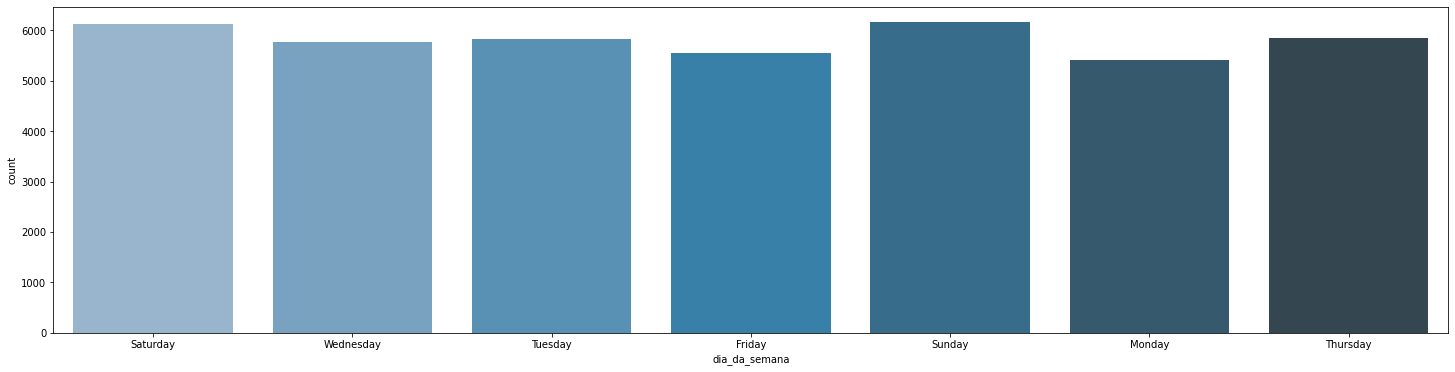

Tabela de Dupla entrada - Conversion x dia da Semana
Conversionsum         0         1         2  All
dia_da_semana                                   
Friday         0.937004  0.062996  0.000000  1.0
Monday         0.933075  0.066741  0.000185  1.0
Saturday       0.928513  0.071324  0.000163  1.0
Sunday         0.934535  0.065465  0.000000  1.0
Thursday       0.937938  0.062062  0.000000  1.0
Tuesday        0.933666  0.066334  0.000000  1.0
Wednesday      0.937630  0.062196  0.000174  1.0
All            0.934573  0.065353  0.000074  1.0


In [137]:
#dflist['dia_mes'] = dflist['dia_mes'].astype(int)
plt.figure(figsize=(25,6))
sns.countplot(x='dia_da_semana', data=dflist,palette="PuBu_d")
plt.show()
print("Tabela de Dupla entrada - Conversion x dia da Semana")
tab = pd.crosstab(index=[dflist["dia_da_semana"]],columns=dflist["Conversionsum"],margins=True)
print(tab.div(tab["All"], axis=0))

**Hora do dia** - Distribuição das Listas

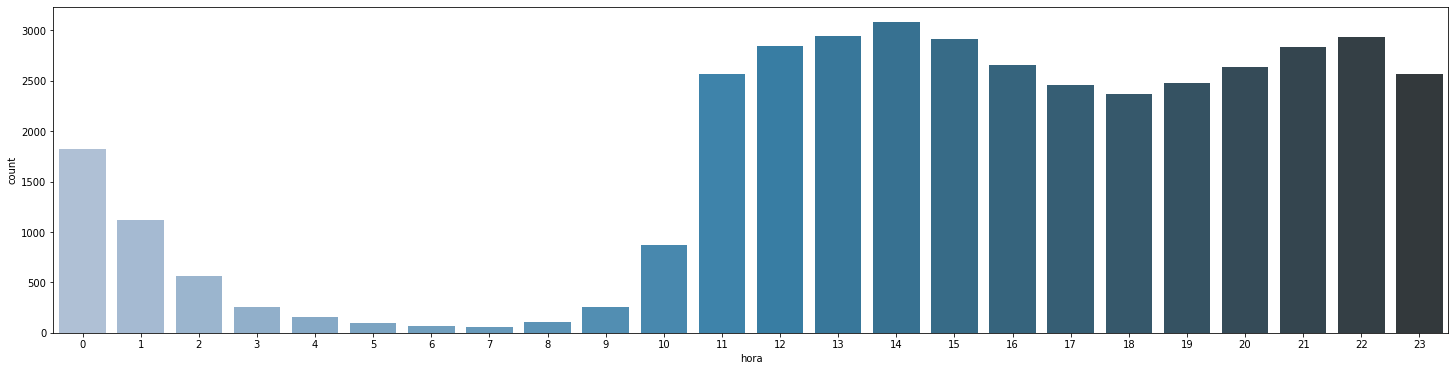

Tabela de Dupla entrada - Conversion x hora
Conversionsum         0         1         2  All
hora                                            
0              0.952721  0.047279  0.000000  1.0
1              0.982990  0.017010  0.000000  1.0
2              0.982301  0.017699  0.000000  1.0
3              1.000000  0.000000  0.000000  1.0
4              1.000000  0.000000  0.000000  1.0
5              1.000000  0.000000  0.000000  1.0
6              1.000000  0.000000  0.000000  1.0
7              0.983871  0.016129  0.000000  1.0
8              1.000000  0.000000  0.000000  1.0
9              0.988462  0.011538  0.000000  1.0
10             0.954023  0.045977  0.000000  1.0
11             0.950992  0.049008  0.000000  1.0
12             0.945794  0.054206  0.000000  1.0
13             0.938817  0.061183  0.000000  1.0
14             0.925000  0.075000  0.000000  1.0
15             0.909622  0.090378  0.000000  1.0
16             0.919519  0.080105  0.000376  1.0
17             0.937704  

In [138]:
dflist['hora'] = dflist['hora'].astype(int)
plt.figure(figsize=(25,6))
sns.countplot(x='hora', data=dflist,palette="PuBu_d")
plt.show()
print("Tabela de Dupla entrada - Conversion x hora")
tab = pd.crosstab(index=[dflist["hora"]],columns=dflist["Conversionsum"],margins=True)
print(tab.div(tab["All"], axis=0))

Transformação Binarias das variáveis:

- dia_da_semana
- dia_mes
- hora

In [139]:
dft = pd.get_dummies(dft, columns = ['dia_da_semana','dia_mes','hora'])

In [140]:
dft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 615162 entries, 0 to 615931
Data columns (total 94 columns):
 #   Column                                     Non-Null Count   Dtype              
---  ------                                     --------------   -----              
 0   DealerId                                   615162 non-null  object             
 1   Conversion                                 615162 non-null  int64              
 2   deviceid                                   615162 non-null  object             
 3   EventTimestamp                             615162 non-null  datetime64[ns, UTC]
 4   DealerOpened                               615162 non-null  bool               
 5   Position                                   615162 non-null  int64              
 6   Quality                                    615162 non-null  float64            
 7   Price                                      615162 non-null  float64            
 8   SearchId                  

# Preparação dos dados para Modelo

Ao analisar as listas, nota-se que em uma lista poderá haver uma única conversão. Assim, a base de estudo para avaliar os fatores que influenciam a conversão das vendas, será a partir da tabela agrupada por lista.

## Seleção Estado de São Paulo

In [141]:
# Selecionando apenas as listas de usuários do Estado de São Paulo

dft =  dft[dft['State']=='Sao Paulo']

### Agrupando o DataFrame por Lista

In [142]:
# Criando o preco de conversão apenas na linhas com Conversion = 1

def conv(dft):
    conv = dft['Conversion']  
    if conv == 1: return dft["Price"]
    return 0
dft['Price_conv'] = dft.apply(conv, axis=1)


In [143]:
# Criando o quality de conversão apenas na linhas com Conversion = 1

def conv(dft):
    conv = dft['Conversion']  
    if conv == 1: return dft["Quality"]
    return 0
dft['Quality_conv'] = dft.apply(conv, axis=1)


In [144]:
# Visualiando todo o conjunto de dados 

pd.set_option('display.max_columns', len(dft.columns)) # Exibinndo todas as colunas do dft
pd.set_option('display.max_rows', 100)
dft.head(5)

DealerId  Conversion  \
0  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0   
1  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0   
2  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0   
3  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0   
4  __+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=           0   

                                         deviceid  \
0  __DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=   
1  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=   
2  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=   
3  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=   
4  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=   

                    EventTimestamp  DealerOpened  Position   Quality  \
0 2019-07-30 23:08:33.941002+00:00         False         7  4.950000   
1 2019-06-01 17:23:21.881002+00:00          True         2  4.840000   
2 2019-06-01 21:43:12.103002+00:00          True         3  4.840000   
3 2019-06-02 16:58:04.585006+00:00         False         3  4.846154   
4 2019-06-02 17:24:35.304002+00:00         False         3  4.846154   

       Price                                           SearchId  \
0  69.989998  __DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=...   
1  69.989998  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...   
2  64.989998  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...   
3  69.989998  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...   
4  69.989998  __DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...   

                      geometry      State  City        date   mes   ano  \
0  POINT (-46.44707 -23.69244)  Sao Paulo  Mauá  30/07/2019  July  2019   
1  POINT (-46.44924 -23.67348)  Sao Paulo  Mauá  01/06/2019  June  2019   
2  POINT (-46.44924 -23.67348)  Sao Paulo  Mauá  01/06/2019  June  2019   
3  POINT (-46.46244 -23.68346)  Sao Paulo  Mauá  02/06/2019  June  2019   
4  POINT (-46.44447 -23.68770)  Sao Paulo  Mauá  02/06/2019  June  2019   

   DealerETAGroup_10-15  DealerETAGroup_15-30  DealerETAGroup_30-45  \
0                     0                     1                     0   
1                     0                     1                     0   
2                     0                     1                     0   
3                     0                     1                     0   
4                     0                     1                     0   

   DealerETAGroup_45-60  Distributor_CONSIGAZ  Distributor_COPAGAZ  \
0                     0                     0                    1   
1                     0                     0                    1   
2                     0                     0                    1   
3                     0                     0                    1   
4                     0                     0                    1   

   Distributor_LIQUIGAS  Distributor_MULTIMARCAS  Distributor_NACIONALGAS  \
0                     0                        0                        0   
1                     0                        0                        0   
2                     0                        0                        0   
3                     0                        0                        0   
4                     0                        0                        0   

   Distributor_SUPERGASBRAS  Distributor_ULTRAGAZ  \
0                         0                     0   
1                         0                     0   
2                         0                     0   
3                         0                     0   
4                         0                     0   

   RecommendationType_BestDeal  RecommendationType_BestDeal,MobileDealer  \
0                            0                                         0   
1                            0                                         0   
2                            0                                         0   
3                            0                                         0   
4                            0    

In [145]:
# Criando uma tabela auxiliar das Listas

dfmod1= dft.groupby(['SearchId'], as_index=False)
dfmod1= dfmod1.agg(n_rev = ("DealerId",'count'),
                  target_conv=('Conversion',max),
                  preco_conv =('Price_conv','max'),
                  preco_medio=('Price','mean'),
                  amplitude_preco=('Price', lambda x: max(x)-min(x)),
                  quality_conv =('Quality_conv','max'),
                  quality_medio=('Quality','mean'),
                  amplitude_quality=('Quality', lambda x: max(x)-min(x)),
                  mean_DealerETAGroup_10_15=('DealerETAGroup_10-15','mean'),
                  mean_DealerETAGroup_15_30=('DealerETAGroup_15-30','mean'),
                  mean_DealerETAGroup_30_45=('DealerETAGroup_30-45','mean'),
                  mean_DealerETAGroup_45_60=('DealerETAGroup_45-60','mean'), 
                  mean_CONSIGAZ =('Distributor_CONSIGAZ','mean'), 
				          mean_COPAGAZ =('Distributor_COPAGAZ','mean'),
				          mean_LIQUIGAS =('Distributor_LIQUIGAS','mean'),
				          mean_MULTIMARCAS =('Distributor_MULTIMARCAS','mean'),
                  mean_NACIONALGAS =('Distributor_NACIONALGAS','mean'),
                  mean_SUPERGASBRAS=('Distributor_SUPERGASBRAS','mean'),
                  mean_ULTRAGAZ=('Distributor_ULTRAGAZ','mean'),
                  mean_BestDeal=('RecommendationType_BestDeal','mean'),
                  mean_BestPrice=('RecommendationType_BestPrice','mean'),
                  mean_BestPrice_MobileDealer=('RecommendationType_BestPrice,MobileDealer','mean'),
                  mean_MobileDealer =('RecommendationType_MobileDealer','mean'),
                  mean_N_A =('RecommendationType_N/A','mean'),
				  )
dfmod1.columns = list(map(''.join, dfmod1.columns.values))

In [146]:
dfmod1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31720 entries, 0 to 31719
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SearchId                     31720 non-null  object 
 1   n_rev                        31720 non-null  int64  
 2   target_conv                  31720 non-null  int64  
 3   preco_conv                   31720 non-null  float64
 4   preco_medio                  31720 non-null  float64
 5   amplitude_preco              31720 non-null  float64
 6   quality_conv                 31720 non-null  float64
 7   quality_medio                31720 non-null  float64
 8   amplitude_quality            31720 non-null  float64
 9   mean_DealerETAGroup_10_15    31720 non-null  float64
 10  mean_DealerETAGroup_15_30    31720 non-null  float64
 11  mean_DealerETAGroup_30_45    31720 non-null  float64
 12  mean_DealerETAGroup_45_60    31720 non-null  float64
 13  mean_CONSIGAZ   

In [147]:
dfmod1.head(5)

SearchId  n_rev  target_conv  \
0  __++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=...     10            0   
1  __++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=...     27            1   
2  __++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=...     24            0   
3  __++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=...      9            0   
4  __+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=...     12            0   

   preco_conv  preco_medio  amplitude_preco  quality_conv  quality_medio  \
0        0.00    72.971000            11.00           0.0       4.730000   
1       68.99    71.435556            33.04           4.9       4.500000   
2        0.00    81.125000            15.00           0.0       4.679167   
3        0.00    70.652222            12.02           0.0       4.400000   
4        0.00    69.815000            11.03           0.0       4.466667   

   amplitude_quality  mean_DealerETAGroup_10_15  mean_DealerETAGroup_15_30  \
0                0.8                        0.0                   0.700000   
1                1.1                        0.0                   0.740741   
2                0.8                        0.0                   0.916667   
3                0.6                        0.0                   0.222222   
4                0.6                        0.0                   0.583333   

   mean_DealerETAGroup_30_45  mean_DealerETAGroup_45_60  mean_CONSIGAZ  \
0                   0.200000                   0.100000       0.100000   
1                   0.148148                   0.111111       0.074074   
2                   0.083333                   0.000000       0.083333   
3                   0.444444                   0.333333       0.111111   
4                   0.083333                   0.333333       0.166667   

   mean_COPAGAZ  mean_LIQUIGAS  mean_MULTIMARCAS  mean_NACIONALGAS  \
0      0.300000       0.000000          0.500000          0.100000   
1      0.259259       0.000000          0.185185          0.148148   
2      0.125000       0.291667          0.333333          0.125000   
3      0.000000       0.222222          0.555556          0.000000   
4      0.000000       0.250000          0.416667          0.083333   

   mean_SUPERGASBRAS  mean_ULTRAGAZ  mean_BestDeal  mean_BestPrice  \
0           0.000000       0.000000            0.0             0.1   
1           0.259259       0.074074            0.0             0.0   
2           0.041667       0.000000            0.0             0.0   
3           0.000000       0.111111            0.0             0.0   
4           0.000000       0.083333            0.0             0.0   

   mean_BestPrice_MobileDealer  mean_MobileDealer  mean_N_A  
0                          0.0                0.0       0.9  
1                          0.0                0.0       1.0  
2                          0.0                0.0       1.0  
3                          0.0                0.0       1.0  
4                          0.0                0.0       1.0

In [148]:
dft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 507514 entries, 0 to 615931
Data columns (total 96 columns):
 #   Column                                     Non-Null Count   Dtype              
---  ------                                     --------------   -----              
 0   DealerId                                   507514 non-null  object             
 1   Conversion                                 507514 non-null  int64              
 2   deviceid                                   507514 non-null  object             
 3   EventTimestamp                             507514 non-null  datetime64[ns, UTC]
 4   DealerOpened                               507514 non-null  bool               
 5   Position                                   507514 non-null  int64              
 6   Quality                                    507514 non-null  float64            
 7   Price                                      507514 non-null  float64            
 8   SearchId                  

In [149]:
# Selecionando as demais colunas do dft binárias 

col = list(dft.columns[32:94])
dfmod2 = dft.groupby(['SearchId'], as_index=False)[col].agg("max")

In [150]:
dfmod = pd.merge(dfmod1,dfmod2, how="left", on='SearchId')
dfmod=dfmod.set_index("SearchId")

In [151]:
dfmod.head()

n_rev  target_conv  \
SearchId                                                                 
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...     10            0   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...     27            1   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...     24            0   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|...      9            0   
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|...     12            0   

                                                    preco_conv  preco_medio  \
SearchId                                                                      
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...        0.00    72.971000   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...       68.99    71.435556   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...        0.00    81.125000   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|...        0.00    70.652222   
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|...        0.00    69.815000   

                                                    amplitude_preco  \
SearchId                                                              
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...            11.00   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...            33.04   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...            15.00   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|...            12.02   
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|...            11.03   

                                                    quality_conv  \
SearchId                                                           
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...           0.0   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...           4.9   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...           0.0   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|...           0.0   
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|...           0.0   

                                                    quality_medio  \
SearchId                                                            
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...       4.730000   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...       4.500000   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...       4.679167   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|...       4.400000   
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|...       4.466667   

                                                    amplitude_quality  \
SearchId                                                                
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...                0.8   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...                1.1   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...                0.8   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|...                0.6   
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|...                0.6   

                                                    mean_DealerETAGroup_10_15  \
SearchId                                                                        
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...                        0.0   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...                        0.0   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...                        0.0   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|...                        0.0   
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|...                        0.0   

                                                    mean_DealerETAGroup_15_30  \
SearchId                                                                        
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|...                   0.700000   
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|...                   0.740741   
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|...                   0.916667   
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52

Substituindo o preço médio na lista convertida pelo preço convertido

In [152]:
dfmod.loc[dfmod['target_conv'] > 0, 'preco_medio'] = dfmod.preco_conv
dfmod = dfmod.drop('preco_conv', axis=1)
dfmod.loc[dfmod['target_conv'] > 0, 'quality_medio'] = dfmod.quality_conv
dfmod = dfmod.drop('quality_conv', axis=1)

### Seleção das Variáveis (Mutual information)

In [153]:
# Dividindo o dataframe (tdf) entre variáveis explicativas (X) e de resposta (Y)
X= dfmod.drop('target_conv', axis=1)
y = dfmod.target_conv

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [154]:
# Separando o conjunto de dados treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=123)

In [155]:
# definindo o modelo de seleção. 
mi = mutual_info_classif(X_train.fillna(0), y_train)
mi

array([5.54936510e-04, 1.96684464e-01, 1.49657040e-03, 2.20939369e-01,
       5.06097021e-03, 5.88898456e-03, 2.91274572e-03, 3.08999678e-03,
       2.29646782e-03, 2.52992418e-03, 0.00000000e+00, 2.06870756e-03,
       1.71620322e-03, 2.11916752e-03, 2.20704889e-03, 2.32228344e-03,
       2.89255171e-03, 7.84459875e-04, 1.15321826e-03, 3.14235508e-03,
       3.17333094e-03, 1.77899071e-03, 3.68282680e-03, 2.39909789e-03,
       1.60751624e-03, 1.78895723e-03, 1.96388633e-03, 1.50896072e-03,
       3.25463928e-03, 2.78042133e-03, 3.30943808e-03, 0.00000000e+00,
       2.01878664e-03, 3.14012949e-04, 1.39631576e-03, 0.00000000e+00,
       2.44419137e-03, 4.18761164e-03, 9.16719363e-04, 2.21435706e-03,
       0.00000000e+00, 5.33744399e-04, 3.23935088e-03, 2.75776870e-03,
       1.42436034e-03, 4.07831997e-04, 1.90519582e-03, 8.67494457e-04,
       8.99444194e-04, 4.27497020e-03, 0.00000000e+00, 0.00000000e+00,
       2.06436298e-03, 1.71877352e-03, 6.55949811e-04, 1.83878967e-03,
      

In [156]:
# Ranking da variáveis explicativas
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False)

quality_medio                  0.220939
preco_medio                    0.196684
mean_DealerETAGroup_10_15      0.005889
amplitude_quality              0.005061
hora_23                        0.004525
dia_mes_22                     0.004275
hora_11                        0.004239
dia_mes_10                     0.004188
hora_12                        0.004059
dia_da_semana_Monday           0.003683
dia_mes_03                     0.003309
dia_mes_01                     0.003255
dia_mes_15                     0.003239
mean_N_A                       0.003173
mean_MobileDealer              0.003142
hora_10                        0.003129
mean_DealerETAGroup_30_45      0.003090
mean_DealerETAGroup_15_30      0.002913
hora_20                        0.002904
mean_BestDeal                  0.002893
dia_mes_02                     0.002780
dia_mes_16                     0.002758
hora_17                        0.002663
mean_CONSIGAZ                  0.002530
hora_01                        0.002493


In [157]:
mi

n_rev                          0.000555
preco_medio                    0.196684
amplitude_preco                0.001497
quality_medio                  0.220939
amplitude_quality              0.005061
mean_DealerETAGroup_10_15      0.005889
mean_DealerETAGroup_15_30      0.002913
mean_DealerETAGroup_30_45      0.003090
mean_DealerETAGroup_45_60      0.002296
mean_CONSIGAZ                  0.002530
mean_COPAGAZ                   0.000000
mean_LIQUIGAS                  0.002069
mean_MULTIMARCAS               0.001716
mean_NACIONALGAS               0.002119
mean_SUPERGASBRAS              0.002207
mean_ULTRAGAZ                  0.002322
mean_BestDeal                  0.002893
mean_BestPrice                 0.000784
mean_BestPrice_MobileDealer    0.001153
mean_MobileDealer              0.003142
mean_N_A                       0.003173
dia_da_semana_Friday           0.001779
dia_da_semana_Monday           0.003683
dia_da_semana_Saturday         0.002399
dia_da_semana_Sunday           0.001608


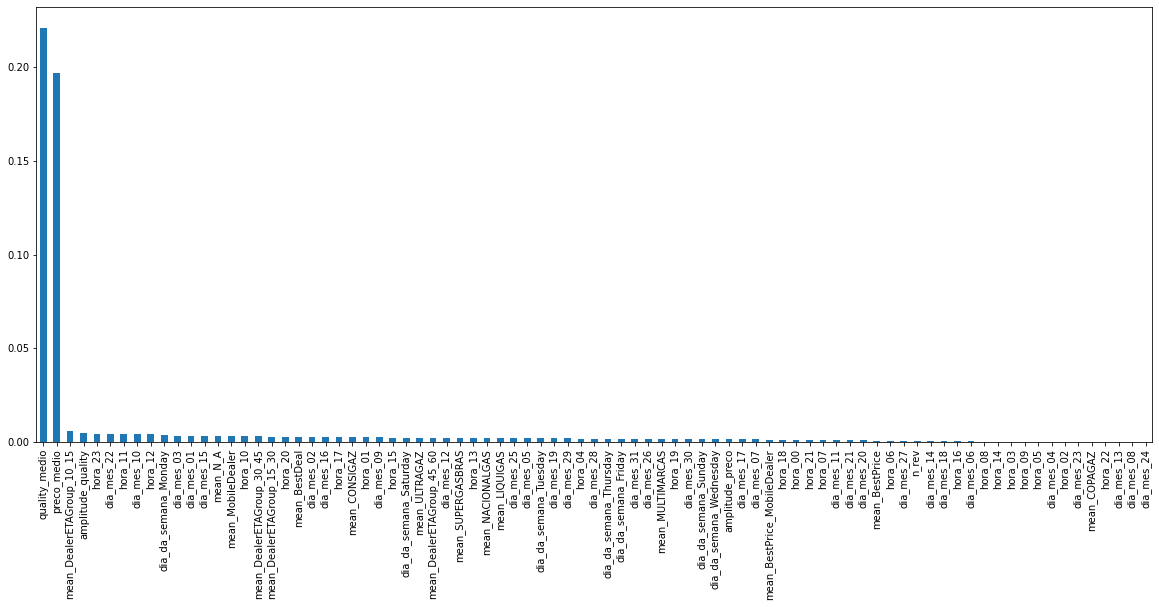

In [158]:
# Ranking da variáveis explicativas por gráfico
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [159]:
# Selecionando 30% das 66 variáveis do dataframe do modelo (tdf) conforme o ranking
#sel_ = SelectPercentile(mutual_info_regression, percentile=60).fit(X_train.fillna(0), y_train)
#df_var_mod = X_train.columns[sel_.get_support()]

In [160]:
# Listando 30% as variáveis importantes
#df_var_mod

In [161]:
mi.sort_values(ascending=False)

quality_medio                  0.220939
preco_medio                    0.196684
mean_DealerETAGroup_10_15      0.005889
amplitude_quality              0.005061
hora_23                        0.004525
dia_mes_22                     0.004275
hora_11                        0.004239
dia_mes_10                     0.004188
hora_12                        0.004059
dia_da_semana_Monday           0.003683
dia_mes_03                     0.003309
dia_mes_01                     0.003255
dia_mes_15                     0.003239
mean_N_A                       0.003173
mean_MobileDealer              0.003142
hora_10                        0.003129
mean_DealerETAGroup_30_45      0.003090
mean_DealerETAGroup_15_30      0.002913
hora_20                        0.002904
mean_BestDeal                  0.002893
dia_mes_02                     0.002780
dia_mes_16                     0.002758
hora_17                        0.002663
mean_CONSIGAZ                  0.002530
hora_01                        0.002493


In [162]:
# dropando da base dfmod variáveis consideradas pelo modelo MI sem informação
cols_to_drop = ['dia_mes_31',
                'hora_08',
                'dia_mes_25',
                'hora_07',
                'hora_06',
                'dia_mes_30',
                'dia_mes_29',
                'dia_mes_27',
                'mean_BestDeal',
                'mean_BestPrice_MobileDealer',
                'dia_mes_18',
                'dia_mes_16',
                'dia_mes_01',
                'dia_mes_13',
                'dia_mes_05',
                'dia_mes_14']
dfmod = dfmod.drop(cols_to_drop, axis=1)

### Matriz de Correlação

In [163]:
# Criando um mapa de calor entre os atributos 

def multi_collinearity_heatmap(df, figsize=(11,9)):    
    # Estilo de Visualização
    sns.set(style="white")
    # Matriz de Correlação 
    corr = df.corr()
    # Mascara de tamanho da matriz de correlação 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Configuração do tamanho do gráfico 
    f, ax = plt.subplots(figsize=figsize)
    # Mapas de cores
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Definido o mapa de calor com a proporção correta
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

<Figure size 1800x864 with 0 Axes>

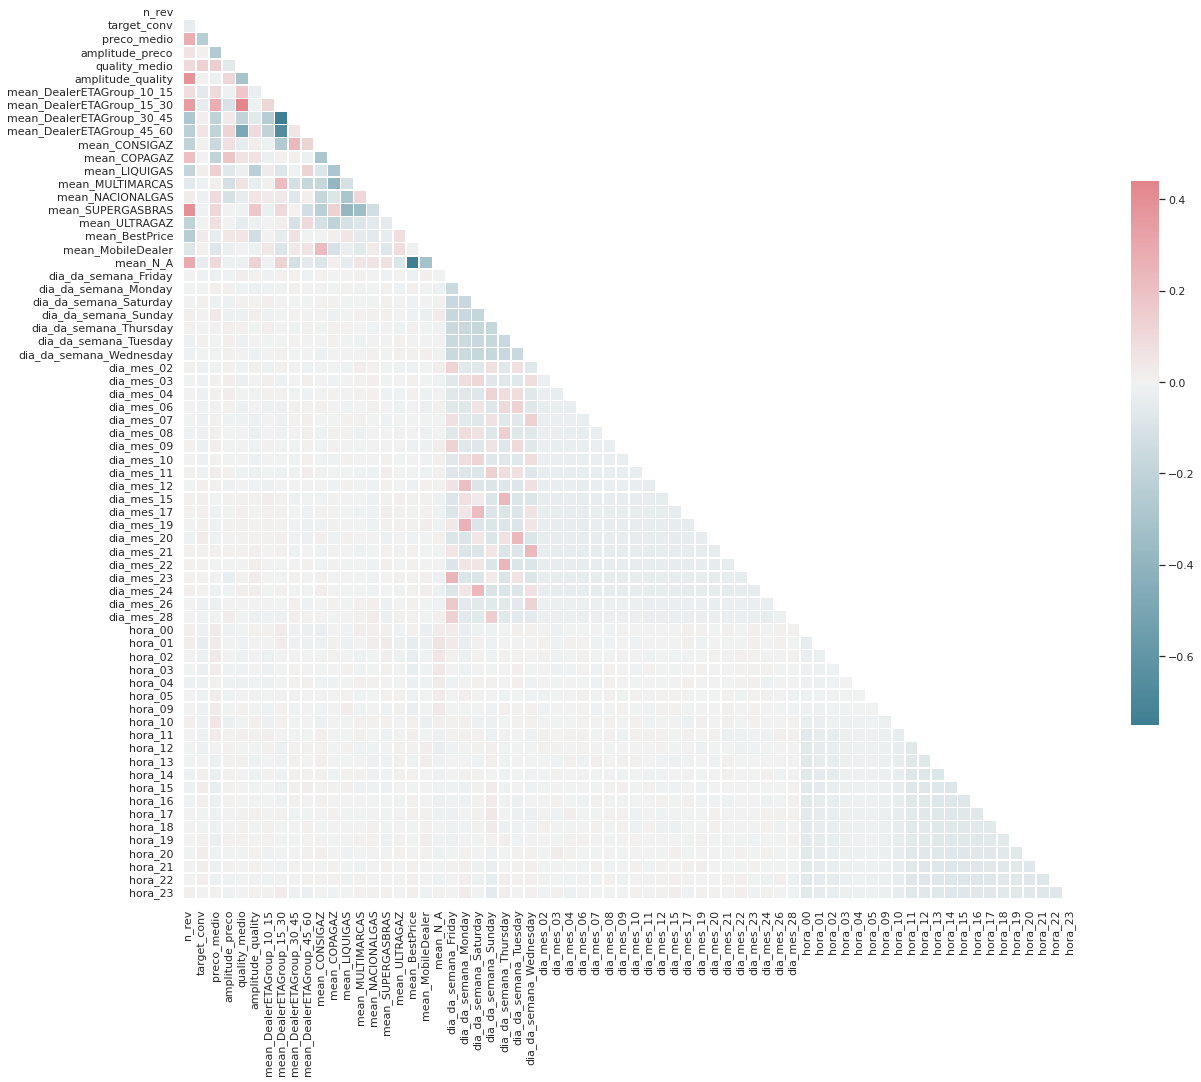

In [164]:
plt.figure(figsize=(25,12))
multi_collinearity_heatmap(dfmod, figsize=(20,20))

# Modelo Preditivo

A intenção ao propor outros modelos de classificação, seria de comparar o desempenho destes com o modelo de referência logístico. No geral, a acurácia dos modelos se mostrara maiores quando comparado ao modelo logístico – exceção do KNN. 
Acurácia dos Modelos:

*	Regressão Logística – 71%;
*	KNN - 60%;
*	Decision Tree Classifier - 81%;
*	Support Vector Machines - 73%;
*	XGBoost - 83%. 

Portanto, para próxima sprint será trabalhando com modelo XGBoot. É importante destacar também, o processo de seleção das variáveis, por meio do método, Mutual Information. 




## Regressão Logistica 

In [220]:
# Separando o conjunto de dados treinamento e teste

X_train, X_test, y_train, y_test = train_test_split(dfmod.drop('target_conv', axis=1),dfmod['target_conv'], test_size=0.2, random_state=0)

In [221]:
# Balanceado o conjunto de dados - grupo controle e grupo tratamento

import random
pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index
if len(pos_index) > len(neg_index):
  higher = pos_index
  lower = neg_index
else:
  higher = neg_index
  lower = pos_index
random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))
X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]


In [222]:
y_train.value_counts()

1    1707
0    1707
Name: target_conv, dtype: int64

In [168]:
X_train.value_counts()

n_rev  preco_medio  amplitude_preco  quality_medio  amplitude_quality  mean_DealerETAGroup_10_15  mean_DealerETAGroup_15_30  mean_DealerETAGroup_30_45  mean_DealerETAGroup_45_60  mean_CONSIGAZ  mean_COPAGAZ  mean_LIQUIGAS  mean_MULTIMARCAS  mean_NACIONALGAS  mean_SUPERGASBRAS  mean_ULTRAGAZ  mean_BestPrice  mean_MobileDealer  mean_N_A  dia_da_semana_Friday  dia_da_semana_Monday  dia_da_semana_Saturday  dia_da_semana_Sunday  dia_da_semana_Thursday  dia_da_semana_Tuesday  dia_da_semana_Wednesday  dia_mes_02  dia_mes_03  dia_mes_04  dia_mes_06  dia_mes_07  dia_mes_08  dia_mes_09  dia_mes_10  dia_mes_11  dia_mes_12  dia_mes_15  dia_mes_17  dia_mes_19  dia_mes_20  dia_mes_21  dia_mes_22  dia_mes_23  dia_mes_24  dia_mes_26  dia_mes_28  hora_00  hora_01  hora_02  hora_03  hora_04  hora_05  hora_09  hora_10  hora_11  hora_12  hora_13  hora_14  hora_15  hora_16  hora_17  hora_18  hora_19  hora_20  hora_21  hora_22  hora_23
14     71.805714    33.100000        4.657143       0.90000            0

In [169]:
# Separando o conjunto de dados treinamento e teste

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=0)

In [170]:
from sklearn.preprocessing import StandardScaler
# Scaling

scaler = StandardScaler()
X_train= pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test= pd.DataFrame(scaler.fit_transform(X_test), columns=list(X_test.columns))

In [171]:
X_train.value_counts()

n_rev      preco_medio  amplitude_preco  quality_medio  amplitude_quality  mean_DealerETAGroup_10_15  mean_DealerETAGroup_15_30  mean_DealerETAGroup_30_45  mean_DealerETAGroup_45_60  mean_CONSIGAZ  mean_COPAGAZ  mean_LIQUIGAS  mean_MULTIMARCAS  mean_NACIONALGAS  mean_SUPERGASBRAS  mean_ULTRAGAZ  mean_BestPrice  mean_MobileDealer  mean_N_A   dia_da_semana_Friday  dia_da_semana_Monday  dia_da_semana_Saturday  dia_da_semana_Sunday  dia_da_semana_Thursday  dia_da_semana_Tuesday  dia_da_semana_Wednesday  dia_mes_02  dia_mes_03  dia_mes_04  dia_mes_06  dia_mes_07  dia_mes_08  dia_mes_09  dia_mes_10  dia_mes_11  dia_mes_12  dia_mes_15  dia_mes_17  dia_mes_19  dia_mes_20  dia_mes_21  dia_mes_22  dia_mes_23  dia_mes_24  dia_mes_26  dia_mes_28  hora_00    hora_01    hora_02   hora_03    hora_04    hora_05    hora_09    hora_10    hora_11    hora_12    hora_13    hora_14    hora_15    hora_16    hora_17    hora_18    hora_19    hora_20    hora_21    hora_22    hora_23  
-0.236625   0.045522     1

In [172]:
# summarize the dataset
print(X_train.shape,X_test.shape)

(2731, 67) (683, 67)


In [173]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Matriz Confusão \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Matriz Confusão 
 [[257  86]
 [ 93 247]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       343
           1       0.74      0.73      0.73       340

    accuracy                           0.74       683
   macro avg       0.74      0.74      0.74       683
weighted avg       0.74      0.74      0.74       683



In [174]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [175]:
accuracies

array([0.75547445, 0.75091575, 0.71062271, 0.73260073, 0.6996337 ,
       0.70695971, 0.72527473, 0.71062271, 0.72161172, 0.74725275])

In [176]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
rfe = RFE(classifier, 30) # definir o número de variáveis a serem consideradas
rfe = rfe.fit(X_train, y_train)

In [177]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe = RFE(classifier, 19)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False  True False False  True  True  True  True
  True False False False False False False False False False  True False
 False False False False False False False  True False False False False
 False  True False False False False False False False  True False False
 False  True  True  True False False False False False False False False
 False False False False  True False  True]
[ 1  1  1  1 42  1 45 15  1  1  1  1  1 27 26 25 19 36 23 32 44 33  1 41
 18 30 38 37 35 49 39  1 20 40 47 29 28  1 34 22 48 31 46 43 21  1  8 16
 17  1  1  1 24 14 10 12 11  5  6  7 13  9  2  3  1  4  1]


In [178]:
print(rfe.ranking_)

[ 1  1  1  1 42  1 45 15  1  1  1  1  1 27 26 25 19 36 23 32 44 33  1 41
 18 30 38 37 35 49 39  1 20 40 47 29 28  1 34 22 48 31 46 43 21  1  8 16
 17  1  1  1 24 14 10 12 11  5  6  7 13  9  2  3  1  4  1]


In [179]:
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

In [180]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.745814307458143

In [181]:
print("Matriz Confusão \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Matriz Confusão 
 [[271  72]
 [ 95 245]]
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       343
           1       0.77      0.72      0.75       340

    accuracy                           0.76       683
   macro avg       0.76      0.76      0.76       683
weighted avg       0.76      0.76      0.76       683



In [182]:
pd.concat([pd.DataFrame(X_train.columns, columns = ['features']), pd.DataFrame(np.transpose(classifier.coef_), columns = ['coef'])],axis = 1)

features      coef
0                       n_rev  0.162932
1                 preco_medio -1.110367
2             amplitude_preco -0.293095
3               quality_medio  0.639278
4           amplitude_quality -0.221742
5   mean_DealerETAGroup_10_15  0.213962
6   mean_DealerETAGroup_15_30 -0.221744
7   mean_DealerETAGroup_30_45 -0.266103
8   mean_DealerETAGroup_45_60  0.110257
9               mean_CONSIGAZ -0.163236
10               mean_COPAGAZ  0.114493
11              mean_LIQUIGAS -0.126632
12           mean_MULTIMARCAS  0.164203
13           mean_NACIONALGAS -0.135313
14          mean_SUPERGASBRAS -0.438354
15              mean_ULTRAGAZ -0.305526
16             mean_BestPrice -0.265515
17          mean_MobileDealer  0.141438
18                   mean_N_A  0.108823
19       dia_da_semana_Friday       NaN
20       dia_da_semana_Monday       NaN
21     dia_da_semana_Saturday       NaN
22       dia_da_semana_Sunday       NaN
23     dia_da_semana_Thursday       NaN
24      dia_da_semana_Tuesday       NaN
25    dia_da_semana_Wednesday       NaN
26                 dia_mes_02       NaN
27                 dia_mes_03       NaN
28                 dia_mes_04       NaN
29                 dia_mes_06       NaN
30                 dia_mes_07       NaN
31                 dia_mes_08       NaN
32                 dia_mes_09       NaN
33                 dia_mes_10       NaN
34                 dia_mes_11       NaN
35                 dia_mes_12       NaN
36                 dia_mes_15       NaN
37                 dia_mes_17       NaN
38                 dia_mes_19       NaN
39                 dia_mes_20       NaN
40                 dia_mes_21       NaN
41                 dia_mes_22       NaN
42                 dia_mes_23       NaN
43                 dia_mes_24       NaN
44                 dia_mes_26       NaN
45                 dia_mes_28       NaN
46                    hora_00       NaN
47                    hora_01       NaN
48                    hora_02       NaN
49                    hora_03       NaN
50                    hora_04       NaN
51                    hora_05       NaN
52                    hora_09       NaN
53                    hora_10       NaN
54                    hora_11       NaN
55                    hora_12       NaN
56                    hora_13       NaN
57                    hora_14       NaN
58                    hora_15       NaN
59                    hora_16       NaN
60                    hora_17       NaN
61                    hora_18       NaN
62                    hora_19       NaN
63                    hora_20       NaN
64                    hora_21       NaN
65                    hora_22       NaN
66                    hora_23       NaN

## Outros modelos de Classificação



### K-Nearest Neighbors (kNN)

In [183]:

# Criando modelo e treinando com os dados de treino
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# Fazendo a predição nos dados de treino
resultado_knn = knn.predict(X_test)
print('matriz de confusão:')
print(confusion_matrix(y_pred, y_test),'\n')
# Principais métricas de performance
print(classification_report(y_test, resultado_knn))

matriz de confusão:
[[271  95]
 [ 72 245]] 

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       343
           1       0.63      0.56      0.59       340

    accuracy                           0.62       683
   macro avg       0.62      0.62      0.62       683
weighted avg       0.62      0.62      0.62       683



### Decision Tree Classifier

In [184]:
# Criando modelo e treinando com os dados de treino

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
# Fazendo a predição nos dados de treino
resultado_dtc = dtc.predict(X_test)
print(confusion_matrix(y_pred, y_test),"\n")
# Principais métricas de performance
print(classification_report(y_test, resultado_dtc))

[[271  95]
 [ 72 245]] 

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       343
           1       0.95      0.80      0.87       340

    accuracy                           0.88       683
   macro avg       0.89      0.88      0.88       683
weighted avg       0.89      0.88      0.88       683



### Support Vector Machines

In [185]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel = 'linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

svm_cm = confusion_matrix(y_pred, y_test)

print('matriz de confusão:')
print(svm_cm, '\n')
# Principais métricas de performance
print(classification_report(y_test, y_pred))

matriz de confusão:
[[283 107]
 [ 60 233]] 

              precision    recall  f1-score   support

           0       0.73      0.83      0.77       343
           1       0.80      0.69      0.74       340

    accuracy                           0.76       683
   macro avg       0.76      0.76      0.75       683
weighted avg       0.76      0.76      0.75       683



### XGBoost


In [186]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

xgb = confusion_matrix(y_pred, y_test)

print('matriz de confusão:')
print(xgb, '\n')
# Principais métricas de performance
print(classification_report(y_test, y_pred))

matriz de confusão:
[[336  91]
 [  7 249]] 

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       343
           1       0.97      0.73      0.84       340

    accuracy                           0.86       683
   macro avg       0.88      0.86      0.85       683
weighted avg       0.88      0.86      0.85       683



# Salvando o Modelo XGBoost


Após selecionar o melhor modelo (maior acurácia) dentre os apresentados acima, utilize o
código abaixo para “salvar” este modelo. Após salvar o modelo, ele pode ser utilizado
para prever a saída após novas entradas. O módulo a ser utilizado é o “joblib”. A Figura 1
apresenta como esse módulo pode ser utilizado.


In [207]:
# Persistindo o modelo para o disco 

from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [208]:
# salvando o modelo no disco

# observem a extensão ".sav"
xgb_m = "model.sav"

In [209]:
# melhor_modelo = modelo com maior acurácia
# nome_do_arquivo = caminho do local onde deve ser salvo o modelo

joblib.dump(model,xgb_m) 

['model.sav']

In [210]:
!ls

adc.json  CityState.csv  modelo.pk1  model.sav	sample_data  TrainingSet.csv


In [211]:
# Carregando o modelo a partir do disco para a memoria 

model = joblib.load('modelo.pk1')

In [219]:
# verificando os atributos do modelo 

print("Atributos do Modelo: \n\nClasses:{}\n\nEstimators:{}\n\nParametros:{}".format(model.classes_, model.n_estimators,model.base_score))

Atributos do Modelo: 

Classes:[0 1]

Estimators:100

Parametros:0.5


In [ ]:
# Teste de Classificação

In [225]:
import numpy as np
from flask import Flask, request, jsonify
import pickle
import os

app = Flask(__name__)

modelo = pickle.load(open('/content/modelo.pk1','rb'))

In [226]:
@app.route("/")
def verifica_api_online():
  return "API ONLINE v1.0", 200

In [227]:
@app.route('/predict', methods=['POST'])
def predict():
  dados = request.get_json(force=True)
  predicao = modelo.predict(np.array([list(dados.values())]))
  resultado = predicao[0]

  resposta = {'DIABETES': int(resultado)}
  return jsonify(resposta)